<a href="https://colab.research.google.com/github/preetikumari5/Machine-Learning/blob/main/Customer_Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this notebook we will be doing some sentiment analysis in python using two different techniques:
1. VADER (Valence Aware Dictionary and sEntiment Reasoner) - Bag of words approach
2. Roberta Pretrained Model from 🤗
3. Huggingface Pipeline

# Step 0. Read in Data and NLTK Basics

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')

import nltk
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('maxent_ne_chunker_tab')
nltk.download('words')
nltk.download('vader_lexicon')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package maxent_ne_chunker_tab to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package maxent_ne_chunker_tab is already up-to-date!
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [ ]:
df = pd.read_csv('/content/Reviews.csv')

In [ ]:
df.shape

(142748, 10)

In [ ]:
# scaling down the dataset
df = df.head(500)

In [ ]:
df.shape

(500, 10)

In [ ]:
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1.0,1.0,5.0,1.303862e+09,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0.0,0.0,1.0,1.346976e+09,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1.0,1.0,4.0,1.219018e+09,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3.0,3.0,2.0,1.307923e+09,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0.0,0.0,5.0,1.350778e+09,Great taffy,Great taffy at a great price. There was a wid...


#**Quick EDA**

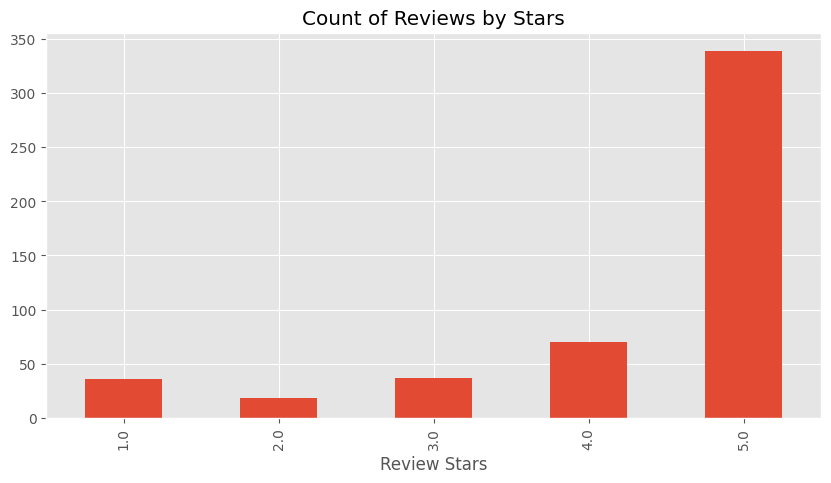

In [ ]:
ax = df['Score'].value_counts().sort_index().plot(kind='bar',
          title='Count of Reviews by Stars',
          figsize=(10,5))
ax.set_xlabel('Review Stars')
plt.show()

# Basic NLTK

In [ ]:
example = df['Text'][50]
print(example)

This oatmeal is not good. Its mushy, soft, I don't like it. Quaker Oats is the way to go.


In [ ]:
nltk.word_tokenize(example)

['This',
 'oatmeal',
 'is',
 'not',
 'good',
 '.',
 'Its',
 'mushy',
 ',',
 'soft',
 ',',
 'I',
 'do',
 "n't",
 'like',
 'it',
 '.',
 'Quaker',
 'Oats',
 'is',
 'the',
 'way',
 'to',
 'go',
 '.']

In [ ]:
tokens = nltk.word_tokenize(example)
tokens[:10]

['This', 'oatmeal', 'is', 'not', 'good', '.', 'Its', 'mushy', ',', 'soft']

In [ ]:
# part of speech tagging
nltk.pos_tag(tokens)

[('This', 'DT'),
 ('oatmeal', 'NN'),
 ('is', 'VBZ'),
 ('not', 'RB'),
 ('good', 'JJ'),
 ('.', '.'),
 ('Its', 'PRP$'),
 ('mushy', 'NN'),
 (',', ','),
 ('soft', 'JJ'),
 (',', ','),
 ('I', 'PRP'),
 ('do', 'VBP'),
 ("n't", 'RB'),
 ('like', 'VB'),
 ('it', 'PRP'),
 ('.', '.'),
 ('Quaker', 'NNP'),
 ('Oats', 'NNPS'),
 ('is', 'VBZ'),
 ('the', 'DT'),
 ('way', 'NN'),
 ('to', 'TO'),
 ('go', 'VB'),
 ('.', '.')]

In [ ]:
tagged = nltk.pos_tag(tokens)
tagged[:10]

[('This', 'DT'),
 ('oatmeal', 'NN'),
 ('is', 'VBZ'),
 ('not', 'RB'),
 ('good', 'JJ'),
 ('.', '.'),
 ('Its', 'PRP$'),
 ('mushy', 'NN'),
 (',', ','),
 ('soft', 'JJ')]

In [ ]:
entities = nltk.chunk.ne_chunk(tagged)
entities.pprint()

(S
  This/DT
  oatmeal/NN
  is/VBZ
  not/RB
  good/JJ
  ./.
  Its/PRP$
  mushy/NN
  ,/,
  soft/JJ
  ,/,
  I/PRP
  do/VBP
  n't/RB
  like/VB
  it/PRP
  ./.
  (ORGANIZATION Quaker/NNP Oats/NNPS)
  is/VBZ
  the/DT
  way/NN
  to/TO
  go/VB
  ./.)


# Step 1. VADER Seniment Scoring

We will use NLTK's `SentimentIntensityAnalyzer` to get the neg/neu/pos scores of the text.

- This uses a "bag of words" approach:
    1. Stop words are removed
    2. each word is scored and combined to a total score.

In [ ]:
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm

sia = SentimentIntensityAnalyzer()

In [ ]:
sia.polarity_scores('I am so happy!')

{'neg': 0.0, 'neu': 0.318, 'pos': 0.682, 'compound': 0.6468}

In [ ]:
sia.polarity_scores('This is the worst thing ever.')

{'neg': 0.451, 'neu': 0.549, 'pos': 0.0, 'compound': -0.6249}

In [ ]:
sia.polarity_scores(example)

{'neg': 0.22, 'neu': 0.78, 'pos': 0.0, 'compound': -0.5448}

In [ ]:
# run the polarity score on the entire dataset
res = {}
for i, row in tqdm(df.iterrows(),total=len(df)):
  text = row['Text']
  myid = row['Id']
  res[myid] = sia.polarity_scores(text)

  0%|          | 0/500 [00:00<?, ?it/s]

In [ ]:
vaders = pd.DataFrame(res).T
vaders = vaders.reset_index().rename(columns={'index':'Id'})
vaders = vaders.merge(df,how='left')

In [ ]:
# sentiment scores and metadata
vaders.head()

,Id,neg,neu,pos,compound,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,0.000,0.695,0.305,0.9441,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1.0,1.0,5.0,1.303862e+09,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,0.138,0.862,0.000,-0.5664,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0.0,0.0,1.0,1.346976e+09,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,0.091,0.754,0.155,0.8265,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1.0,1.0,4.0,1.219018e+09,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,0.000,1.000,0.000,0.0000,B000UA0QIQ,A395BORC6FGVXV,Karl,3.0,3.0,2.0,1.307923e+09,Cough Medicine,If you are looking for the secret ingredient i...
4,5,0.000,0.552,0.448,0.9468,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0.0,0.0,5.0,1.350778e+09,Great taffy,Great taffy at a great price. There was a wid...


# Plot VADER results

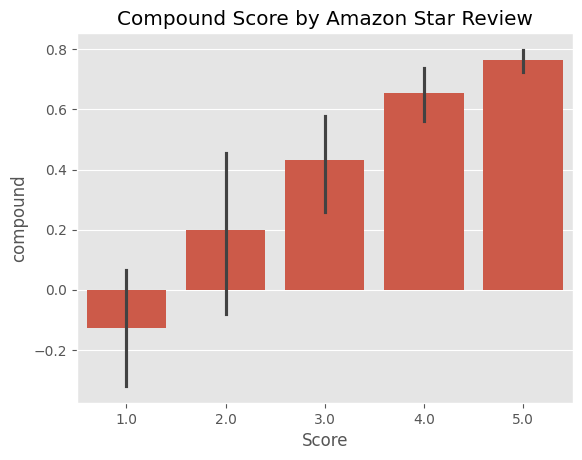

In [ ]:
ax = sns.barplot(data=vaders,x='Score',y='compound')
ax.set_title('Compound Score by Amazon Star Review')
plt.show()

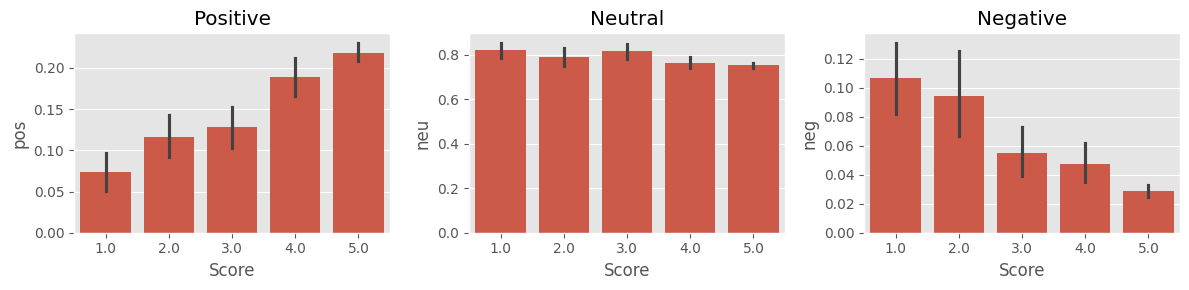

In [ ]:
fig,axis = plt.subplots(1,3,figsize=(12,3))
sns.barplot(data=vaders,x='Score',y='pos',ax=axis[0])
sns.barplot(data=vaders,x='Score',y='neu',ax=axis[1])
sns.barplot(data=vaders,x='Score',y='neg',ax=axis[2])
axis[0].set_title('Positive')
axis[1].set_title('Neutral')
axis[2].set_title('Negative')
plt.tight_layout()
plt.show()

# Step 3. Roberta Pretrained Model

- Use a model trained of a large corpus of data.
- Transformer model accounts for the words but also the context related to other words.

In [ ]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax

In [ ]:
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

config.json:   0%|          | 0.00/747 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

In [ ]:
# vader result on example
print(example)
sia.polarity_scores(example)

This oatmeal is not good. Its mushy, soft, I don't like it. Quaker Oats is the way to go.


{'neg': 0.22, 'neu': 0.78, 'pos': 0.0, 'compound': -0.5448}

In [ ]:
# run for roberta model
encoded_text = tokenizer(example,return_tensors='pt')
output = model(**encoded_text)
scores = output[0][0].detach().numpy()
scores = softmax(scores)
scores_dict = {
    'roberta_neg' : scores[0],
    'roberta_neu' : scores[1],
    'roberta_pos' : scores[2]
}
print(scores_dict)

{'roberta_neg': 0.97635514, 'roberta_neu': 0.020687466, 'roberta_pos': 0.002957372}


In [ ]:
def polarity_scores_roberta(example):
    encoded_text = tokenizer(example, return_tensors='pt')
    output = model(**encoded_text)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    scores_dict = {
        'roberta_neg' : scores[0],
        'roberta_neu' : scores[1],
        'roberta_pos' : scores[2]
    }
    return scores_dict

In [ ]:
res = {}
for i, row in tqdm(df.iterrows(),total=len(df)):
  try:
    text = row['Text']
    myid = row['Id']
    vader_result = sia.polarity_scores(text)
    vader_result_rename = {}
    for key, value in vader_result.items():
      vader_result_rename[f"vader_{key}"] = value
    roberta_result = polarity_scores_roberta(text)
    both = {**vader_result_rename,**roberta_result}
    res[myid] = both
  except RuntimeError:
    print(f'Broke for id {myid}')

  0%|          | 0/500 [00:00<?, ?it/s]

Broke for id 83
Broke for id 187


In [ ]:
results_df = pd.DataFrame(res).T
results_df = results_df.reset_index().rename(columns={'index':'Id'})
results_df = results_df.merge(df,how='left')

# Compare Scores between models

In [ ]:
results_df.columns

Index(['Id', 'vader_neg', 'vader_neu', 'vader_pos', 'vader_compound',
       'roberta_neg', 'roberta_neu', 'roberta_pos', 'ProductId', 'UserId',
       'ProfileName', 'HelpfulnessNumerator', 'HelpfulnessDenominator',
       'Score', 'Time', 'Summary', 'Text'],
      dtype='object')

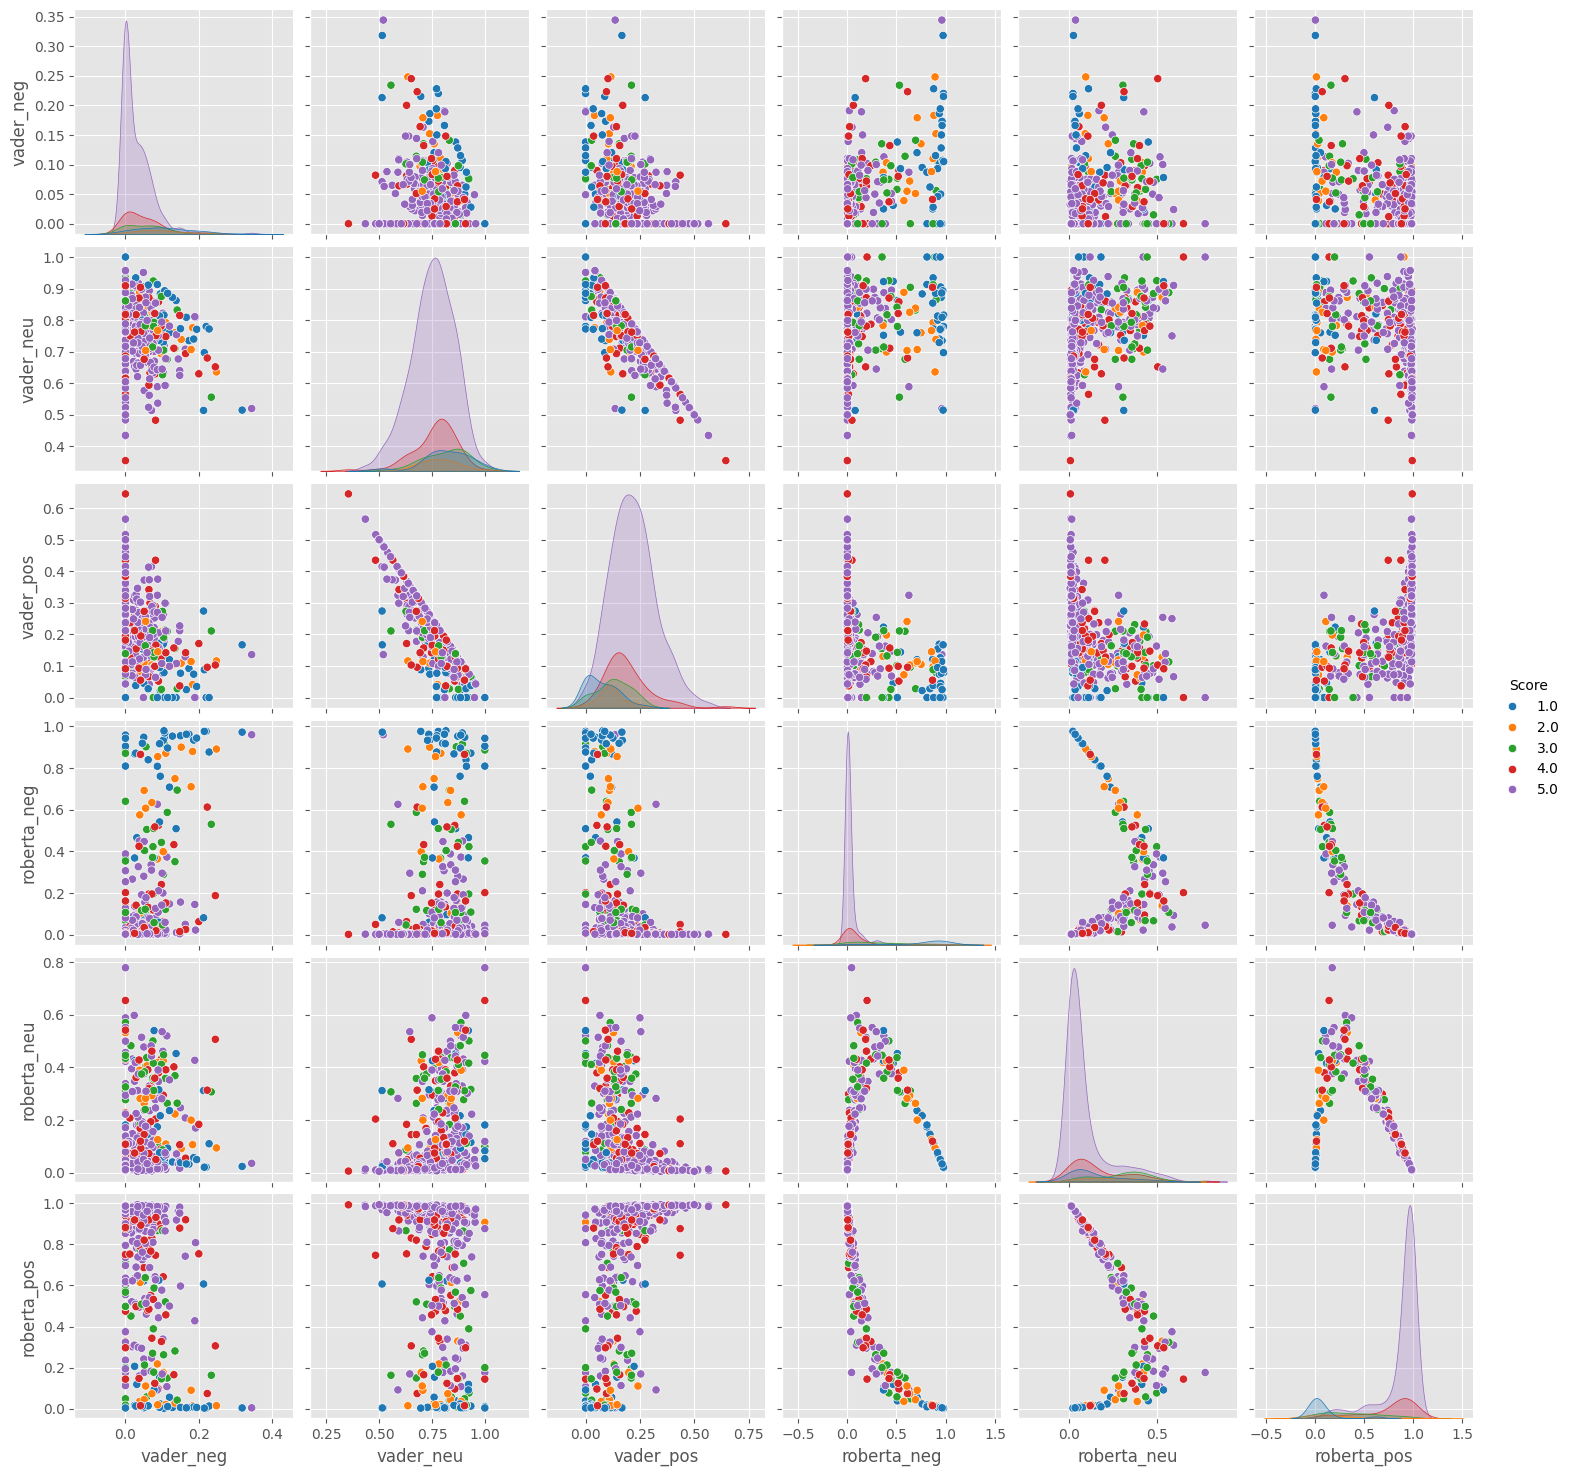

In [ ]:
sns.pairplot(data=results_df,
            vars=['vader_neg','vader_neu','vader_pos',
                  'roberta_neg','roberta_neu','roberta_pos'],
            hue='Score',
            palette='tab10')
plt.show()

# Step 4: Review Examples:

- Positive 1-Star and Negative 5-Star Reviews

Lets look at some examples where the model scoring and review score differ the most.

In [ ]:
results_df.query('Score == 1').sort_values('roberta_pos', ascending=False)['Text'].values[0]

'I felt energized within five minutes, but it lasted for about 45 minutes. I paid $3.99 for this drink. I could have just drunk a cup of coffee and saved my money.'

In [ ]:
results_df.query('Score == 1').sort_values('vader_pos', ascending=False)['Text'].values[0]

'So we cancelled the order.  It was cancelled without any problem.  That is a positive note...'

In [ ]:
results_df.query('Score == 5').sort_values('roberta_neg', ascending=False)['Text'].values[0]

'this was sooooo deliscious but too bad i ate em too fast and gained 2 pds! my fault'

In [ ]:
results_df.query('Score == 5').sort_values('vader_neg', ascending=False)['Text'].values[0]

'this was sooooo deliscious but too bad i ate em too fast and gained 2 pds! my fault'

# Extra: The Transformers Pipeline
- Quick & easy way to run sentiment predictions

In [ ]:
from transformers import pipeline
sent_pipeline = pipeline("sentiment-analysis")

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

Device set to use cpu


In [ ]:
sent_pipeline('I love sentiment analysis!')

[{'label': 'POSITIVE', 'score': 0.9997853636741638}]

In [ ]:
sent_pipeline('Make sure to like and subscribe!')

[{'label': 'POSITIVE', 'score': 0.9991742968559265}]

In [ ]:
sent_pipeline('booo')

[{'label': 'NEGATIVE', 'score': 0.9936267137527466}]